In [1]:
from sklearn import linear_model
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import KFold,cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
df = pd.read_csv('./data_640_validated.csv', encoding='ISO-8859-1')

In [ ]:
#查看缺失值
df.columns[df.isnull().any()]

Index(['A4', 'D1', 'D2', 'D3', 'D4', 'D7'], dtype='object')

### The distribution of the players' length of being self-isolated/social distancing

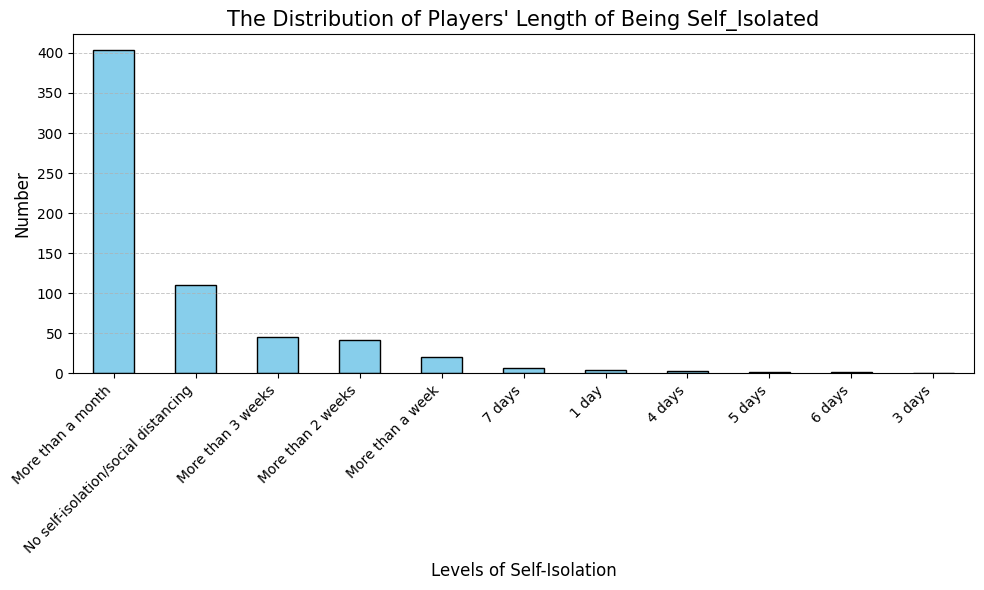

In [ ]:
df_self_isolated = df['B2'].value_counts()
plt.figure(figsize=(10, 6))
df_self_isolated.plot.bar(color='skyblue', edgecolor='black')
plt.title('The Distribution of Players\' Length of Being Self_Isolated', fontsize=15)
plt.xlabel('Levels of Self-Isolation', fontsize=12)
plt.ylabel('Number', fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

### The distribution of the players' length of being self-isolated/social distancing according to regions

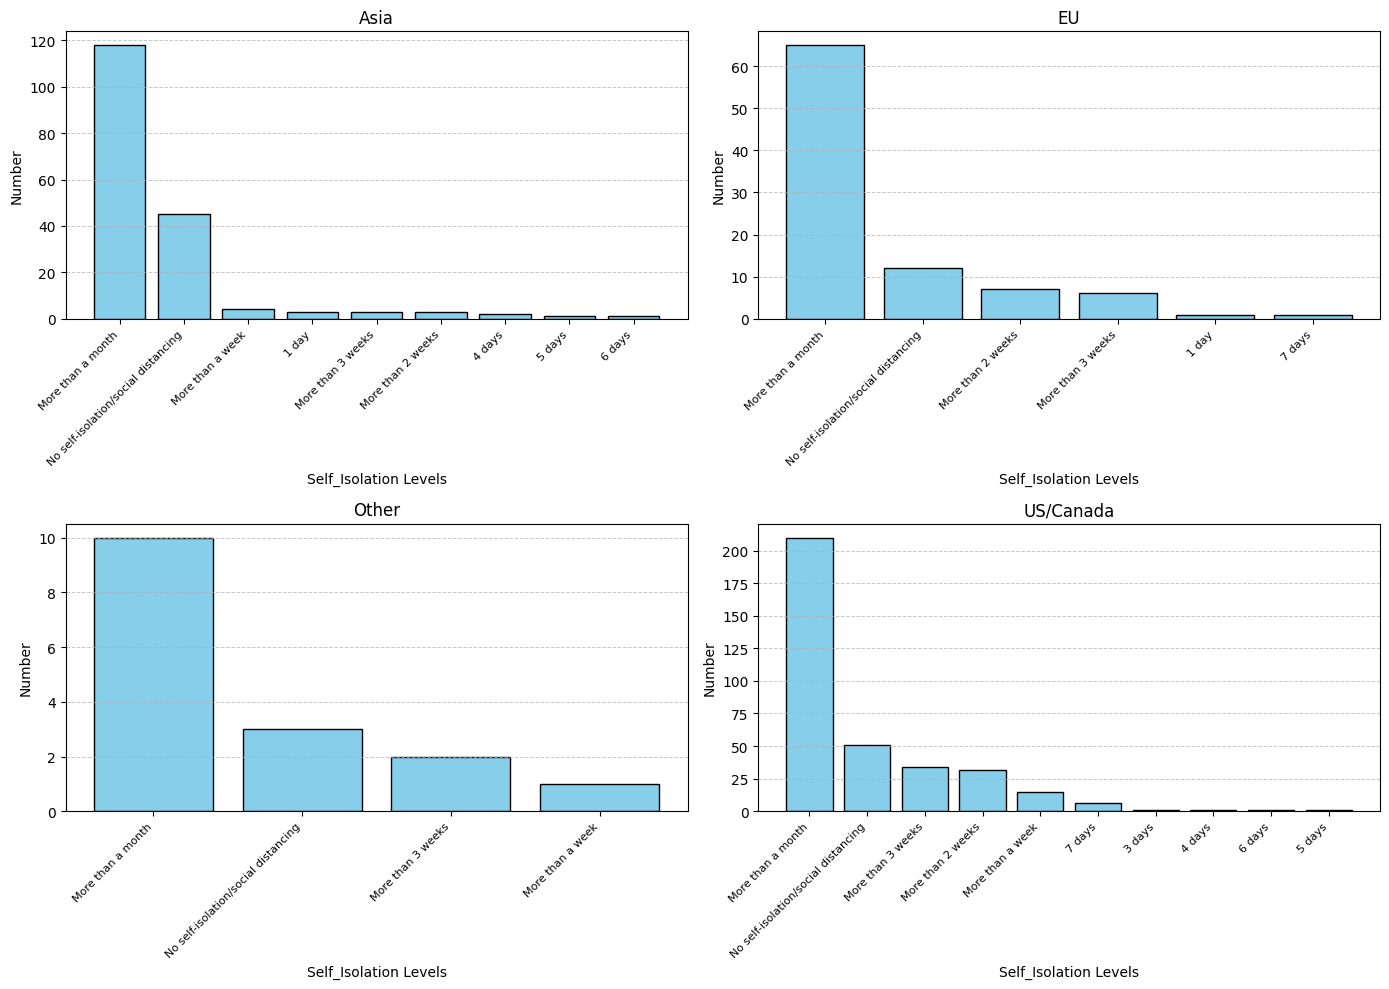

In [ ]:
df_self_isolated_according_to_regions = df.groupby('A1_2')['B2']
fig, axes = plt.subplots(2, 2, figsize=(14, 10)) 
axes = axes.flatten()
for ax, (region_name, region_data) in zip(axes, df_self_isolated_according_to_regions):
    region_counts = region_data.value_counts()
    ax.bar(region_counts.index, region_counts.values, color='skyblue', edgecolor='black')
    ax.set_title(f'{region_name}', fontsize=12)
    ax.set_xlabel('Self_Isolation Levels', fontsize=10)
    ax.set_ylabel('Number', fontsize=10)
    ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
    ax.set_xticks(region_counts.index)
    ax.set_xticklabels(region_counts.index, rotation=45, ha='right', fontsize=8)
plt.tight_layout()
plt.show()




### The relationship between the players' length of being self-isolated/social distancing and the game-playing frequency of the players.

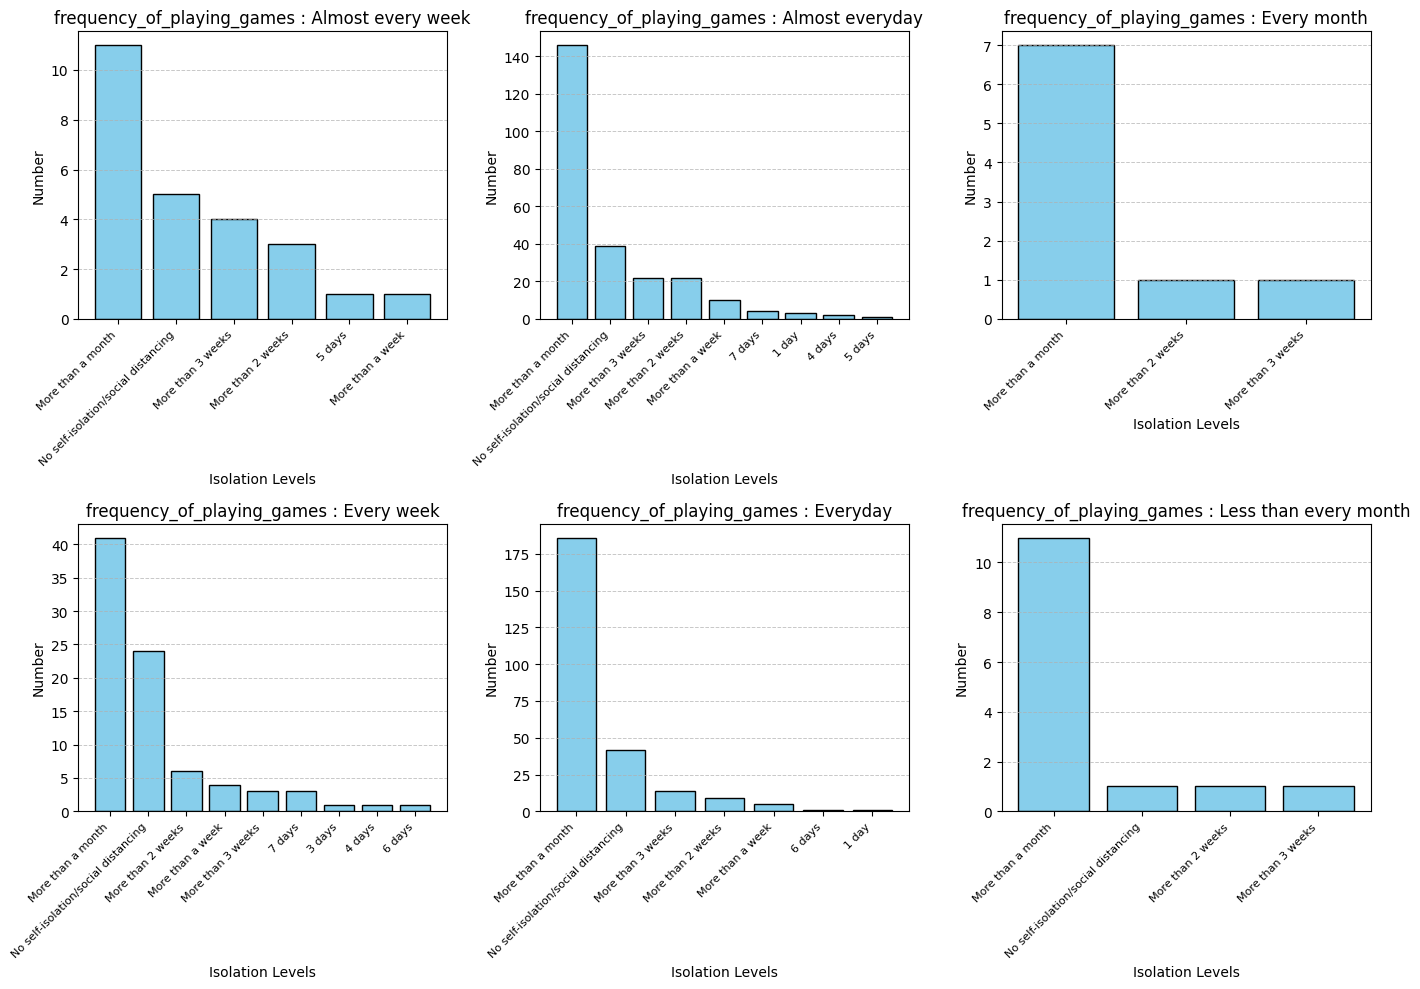

In [ ]:
df_isolated_game_playing = df[['B2', 'D3']].groupby('D3')['B2']
fig, axes = plt.subplots(2, 3, figsize=(14, 10))
axes = axes.flatten()
for ax, (frequency_of_playing_games, self_isolation_levels) in zip(axes, df_isolated_game_playing):
    counts = self_isolation_levels.value_counts()
    ax.bar(counts.index,counts.values, color='skyblue', edgecolor='black')
    ax.set_xlabel('Isolation Levels', fontsize=10)
    ax.set_ylabel('Number', fontsize=10)
    ax.set_title('frequency_of_playing_games : ' + f'{frequency_of_playing_games}', fontsize=12)
    ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
    ax.set_xticks(counts.index)
    ax.set_xticklabels(counts.index, rotation=45, ha='right', fontsize=8)
plt.tight_layout()
plt.show()


###  A comparison of the frequency of the different lengths of being self-isolated/social distancing  and game-playing feeling response “I lost connection with the outside world”

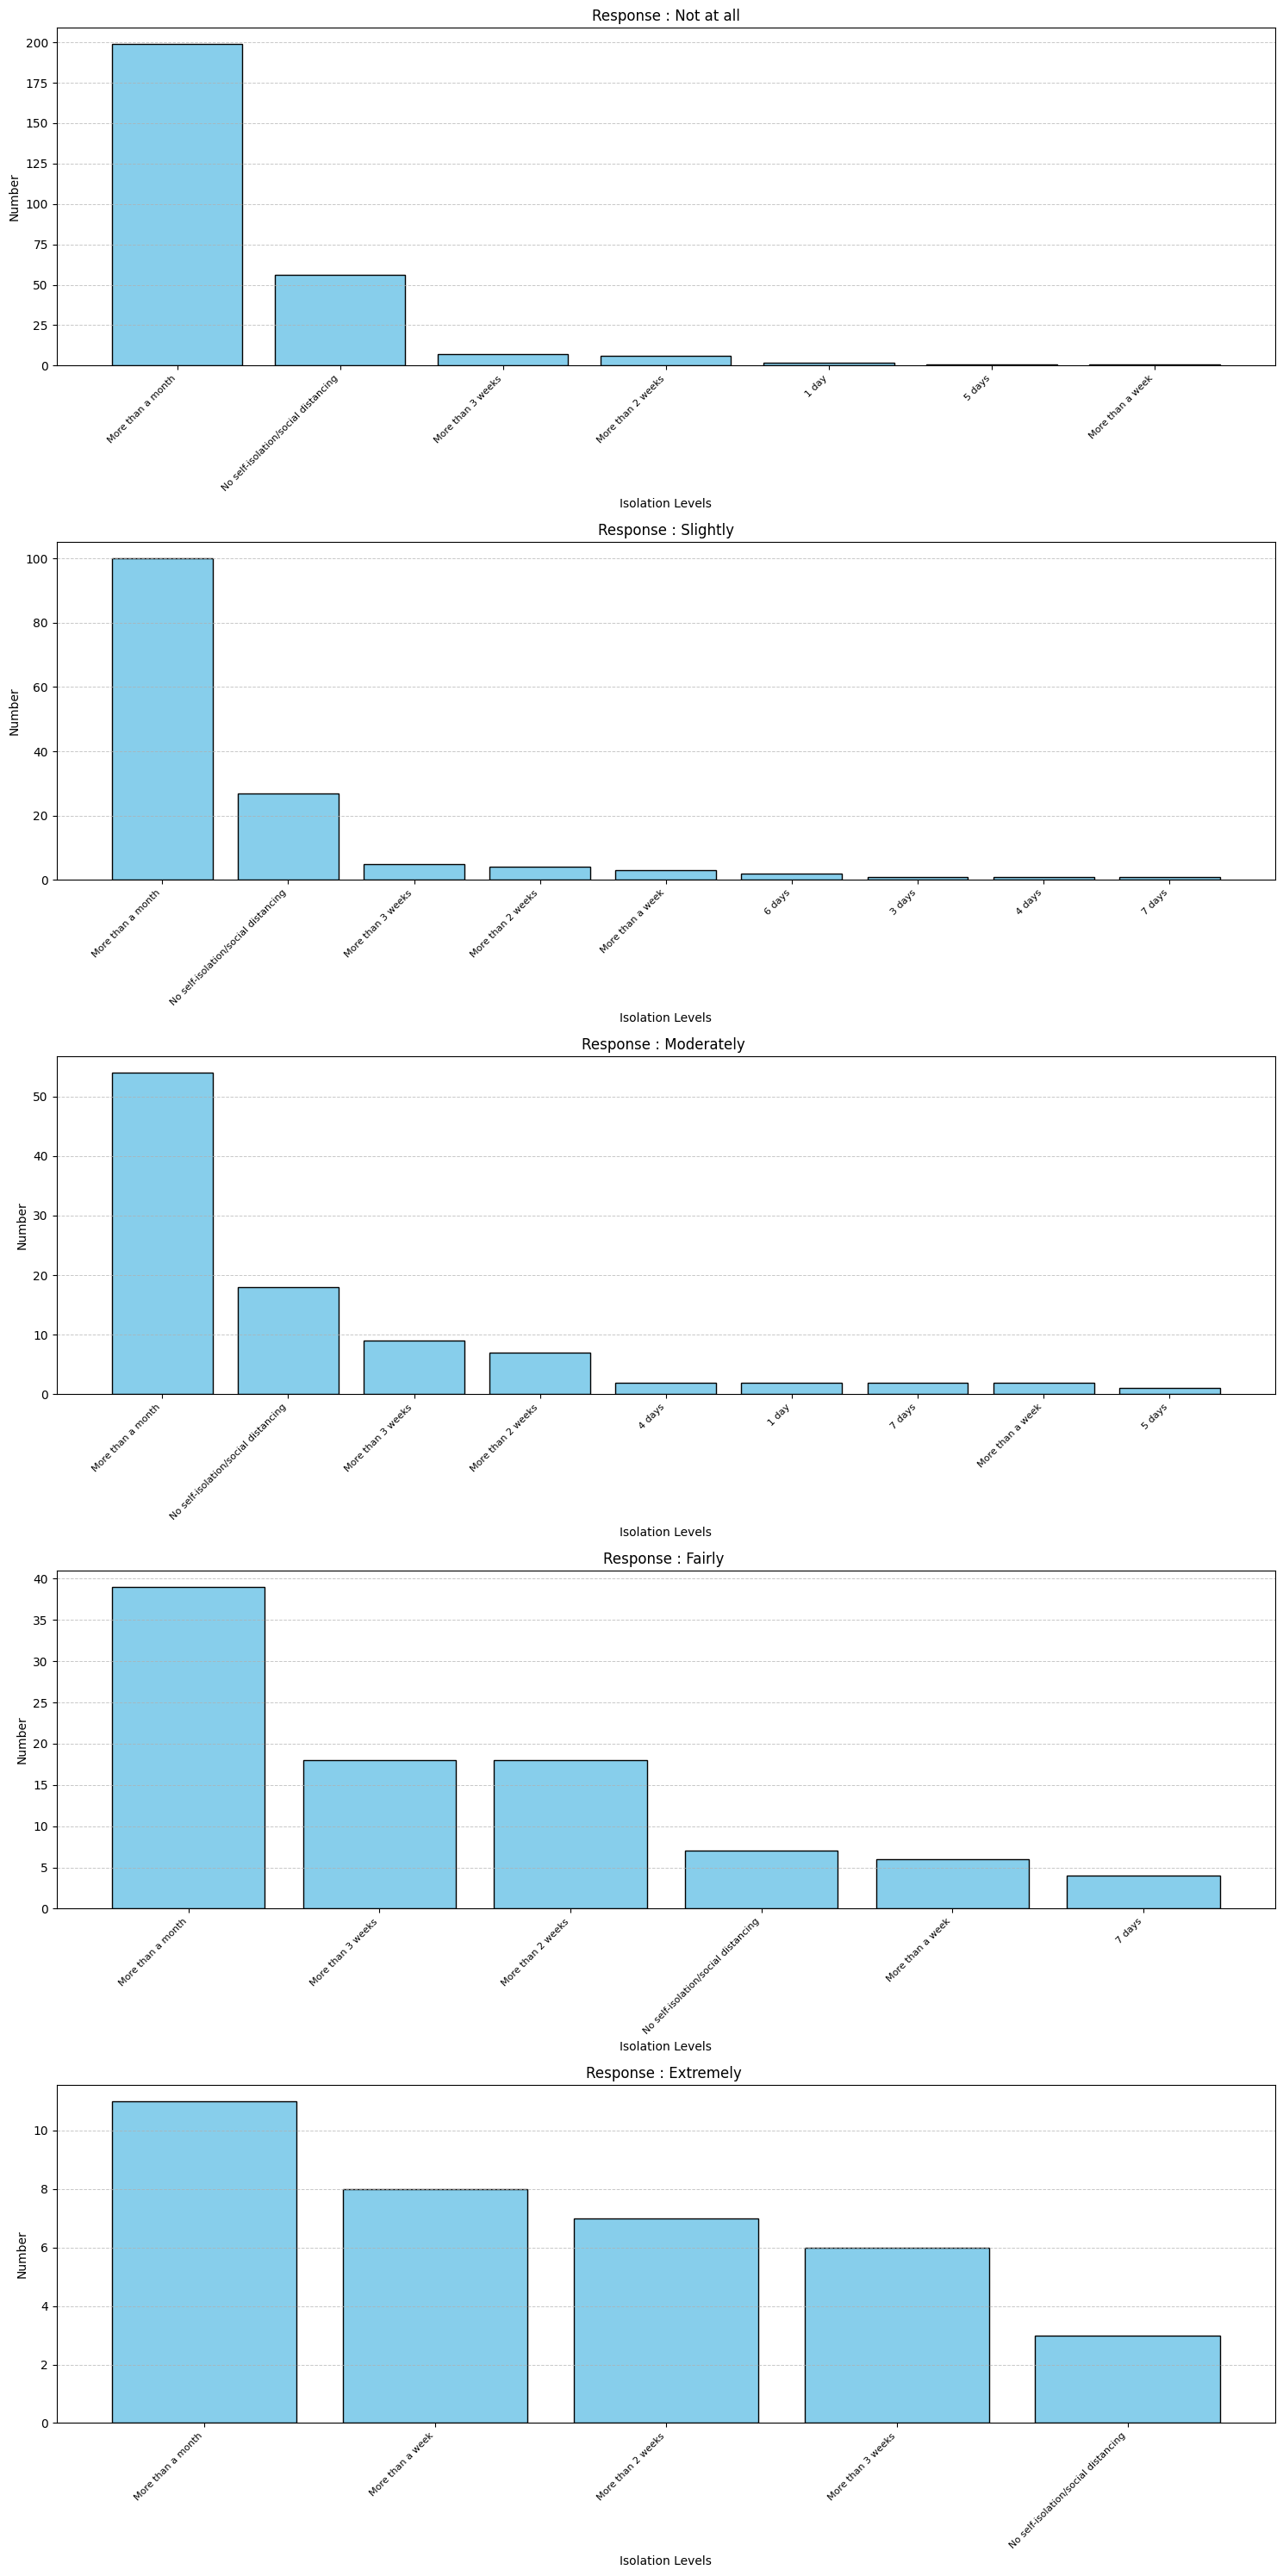

In [ ]:
levels = ['Not at all','Slightly','Moderately ','Fairly ','Extremely ']
iterator = iter(levels)
df_compasion = df[['B2','F32']].groupby('F32')['B2']
fig, axes = plt.subplots(5, 1, figsize=(15,30))
axes = axes.flatten()
for ax, (response, self_isolation_level) in zip(axes, df_compasion):
    counts = self_isolation_level.value_counts()
    ax.bar(counts.index, counts.values, color='skyblue', edgecolor='black')
    ax.set_xlabel('Isolation Levels', fontsize=10)
    ax.set_ylabel('Number', fontsize=10)
    ax.set_title('Response : ' + f'{next(iterator)}', fontsize=12)
    ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
    ax.set_xticks(counts.index)
    ax.set_xticklabels(counts.index, rotation=45, ha='right', fontsize=8)
plt.tight_layout()
plt.show()


### Identify the most important in-game behaviours that indicate the player’s length of being self-isolated/social distancing.  

In [ ]:
df_identify1 = df.iloc[:,36:64]
df_identify2 = df.iloc[:,12]
df_identify = pd.concat([df_identify2,df_identify1],axis=1)

In [ ]:
label_encoder = LabelEncoder()
df_identify['B2'] = label_encoder.fit_transform(df_identify['B2'])
correlation_matrix = df_identify.corr()

In [ ]:
correlation_with_B2 = correlation_matrix['B2'].drop('B2')
top_correlated_columns = correlation_with_B2.abs().sort_values(ascending=False).head(5)
top_correlated_columns

E13    0.174606
E24    0.135522
E17    0.120485
E14    0.116080
E11    0.110567
Name: B2, dtype: float64

### Develop a machine learning model that can be used to predict a player’s length of being self-isolated/ social distancing based on in-game behaviour variables only. To do this, you will need to split the dataset into training, test, and evaluation sets. Evaluate your model’s performance using appropriate metrics. Please describe the method you used for your model, and your motivation for choosing the specific methods. 

In [ ]:
data = df.iloc[:,36:64].values
label = label_encoder.fit_transform(df.iloc[:,12])
label

array([ 8,  8,  8,  8,  7,  8,  7,  8,  8, 10, 10, 10, 10, 10, 10,  8,  8,
        8,  8,  8,  8, 10,  8,  8,  8,  6,  8,  8,  8,  8,  8,  8,  7,  8,
       10,  8,  9,  8,  8,  8,  8,  8,  0, 10,  8,  8,  6,  7,  8,  8,  8,
        8, 10, 10,  8,  8,  3,  8,  9,  8,  8,  9,  8,  8,  1,  8, 10,  8,
        8,  8,  8, 10,  8,  8,  8,  8, 10,  6,  8,  8,  8,  8,  8, 10,  8,
        8,  8,  8,  8,  8, 10,  8, 10,  8,  8,  7,  6,  8,  8,  8,  8,  8,
        8,  8,  8,  6,  8,  8, 10,  8,  8,  8, 10,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  4, 10,  8,  8, 10,  8,  8,
        7,  7,  8,  7, 10,  8,  8,  8,  8,  8, 10,  8,  8,  8, 10,  8,  6,
        8,  8,  8,  8, 10,  8, 10,  8,  8,  8,  8,  8,  8, 10, 10, 10,  2,
        2,  8,  8,  8, 10,  8,  8,  8,  8,  8,  8,  8,  8,  8, 10,  8,  8,
       10, 10,  8,  8,  8,  8,  8,  8,  8,  8,  8,  7,  8,  7,  8,  8, 10,
        8,  8,  8,  8, 10,  8,  8,  0,  8,  8, 10,  8,  8,  7,  8,  7,  8,
        8, 10,  6,  8,  8

In [ ]:
# 查看编码对应关系
categories = label_encoder.classes_
print(categories)

['1 day' '3 days' '4 days' '5 days' '6 days' '7 days' 'More than 2 weeks'
 'More than 3 weeks' 'More than a month' 'More than a week'
 'No self-isolation/social distancing']


In [ ]:
category_mapping = dict(zip(categories, range(len(categories))))
for category, code in category_mapping.items(): 
    print(f"{category}: {code}") 

1 day: 0
3 days: 1
4 days: 2
5 days: 3
6 days: 4
7 days: 5
More than 2 weeks: 6
More than 3 weeks: 7
More than a month: 8
More than a week: 9
No self-isolation/social distancing: 10


In [ ]:
# 计算权重
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(label), y=label)
print(class_weights)

[14.54545455 58.18181818 19.39393939 29.09090909 29.09090909  8.31168831
  1.38528139  1.29292929  0.14437176  2.90909091  0.52416052]


In [ ]:
class_weights = dict(zip(np.arange(0,11),class_weights))
class_weights

{0: 14.545454545454545,
 1: 58.18181818181818,
 2: 19.393939393939394,
 3: 29.09090909090909,
 4: 29.09090909090909,
 5: 8.311688311688311,
 6: 1.3852813852813852,
 7: 1.292929292929293,
 8: 0.14437175727498308,
 9: 2.909090909090909,
 10: 0.5241605241605242}

In [ ]:
label = label.reshape(-1,1)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(data,label,test_size=0.2,shuffle=True,random_state=31)

### SVC

In [ ]:
kfold = KFold(n_splits=5,shuffle=True,random_state=42)
model = SVC(kernel='poly',class_weight=class_weights)
param_grid = {
    'C' : [0.1,1,10],
    'degree':[3,4,5,6,7,8,9,10,11]
}
grid_search = GridSearchCV(estimator=model,param_grid=param_grid,cv=kfold,scoring='f1_weighted')
scaler = StandardScaler()
X_train1 = scaler.fit_transform(X_train)
grid_search.fit(X_train1,y_train)
print('Best Score: ',grid_search.best_score_)

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

Best Score:  0.5725138907763683


D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

### CatBoost

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

sample_weights = [class_weights[element] for element in y_train.squeeze()]
# 定义CatBoost分类器
model = CatBoostClassifier(random_state=42, verbose=0)

# 定义参数网格
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.5,],
    'depth': [4, 6, 8, 12],
    'iterations': [300,600,800]
}

# 使用GridSearchCV进行超参数调优
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train1, y_train, sample_weight=sample_weights)

# 输出最佳参数和评分
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# 使用最佳参数进行预测
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# 评估模型
from sklearn.metrics import classification_report, accuracy_score
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


D:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best Parameters: {'depth': 12, 'iterations': 800, 'learning_rate': 0.2}
Best Score: 0.650466400152294
Accuracy Score: 0.671875
Classification Report:
               precision    recall  f1-score   support

           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         7
           7       0.00      0.00      0.00         8
           8       0.67      1.00      0.80        86
           9       0.00      0.00      0.00         7
          10       0.00      0.00      0.00        18

    accuracy                           0.67       128
   macro avg       0.10      0.14      0.11       128
weighted avg       0.45      0.67      0.54       128



D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Logisticregression

In [ ]:
model = linear_model.LogisticRegression(random_state=1,class_weight=class_weights)
param_grid = {
    'max_iter':[500,1000,1500,2000]
}
grid_search = GridSearchCV(estimator=model,cv=kfold,scoring='f1_weighted',param_grid=param_grid)
grid_search.fit(X_train1,y_train)
print('Best Score: ',grid_search.best_score_)

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

Best Score:  0.45325612993991815


D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
df_identify1 = df.iloc[:,36:64]
df_identify2 = df.iloc[:,12]
df_identify = pd.concat([df_identify2,df_identify1],axis=1)
df_identify

,B2,E1,E2,E3,E4,E5,E6,E7,E8,E9,...,E19,E20,E21,E22,E23,E24,E25,E26,E27,E28
0,More than a month,4,4,4,1,3,5,3,3,2,...,4,4,3,3,2,1,4,4,3,4
1,More than a month,4,4,3,2,3,5,5,5,4,...,2,3,4,3,3,3,4,4,3,4
2,More than a month,4,4,4,3,4,5,5,5,4,...,2,3,4,3,4,3,4,4,4,4
3,More than a month,3,4,4,4,3,5,5,5,5,...,3,4,3,4,2,1,4,4,3,4
4,More than 3 weeks,4,3,3,4,2,5,5,5,2,...,3,3,2,2,2,2,4,3,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,More than a month,2,2,3,1,2,4,4,5,4,...,3,4,3,3,2,2,3,3,2,3
636,More than a month,4,4,4,4,4,5,5,5,5,...,4,4,4,4,4,4,4,4,3,4
637,More than a month,4,4,2,2,4,5,5,5,5,...,3,3,3,3,3,2,4,2,4,3
638,More than a month,3,4,2,3,4,3,4,3,3,...,4,2,2,2,3,2,4,4,4,4


In [ ]:
df_identify.to_csv('data.csv',index=False)